A notebook for finetuning Stable Diffusion using LORA.

Tested with [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

Notebook developed by [pedrogengo](https://github.com/pedrogengo).

# SETUP

In [22]:
%%capture
!git clone https://github.com/cloneofsimo/lora.git
%pip install accelerate bitsandbytes
%pip install tqdm
%pip install diffusers
%pip install transformers
%pip install torchvision
%pip install fire
%pip install scipy
%pip install bitsandbytes

In [23]:
import os
import shutil
import sys
from tqdm import tqdm
# from google.colab import files

In [24]:
%%capture
LORA_PATH = os.path.join(os.getcwd(), "lora")
%pip install lora $LORA_PATH

In [25]:
%%capture
PARENT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
UTILS_PATH = os.path.join(PARENT_PATH, ".conda/lib/python3.8/site-packages/lora_diffusion/xformers_utils.py")
!sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' $UTILS_PATH

In [26]:
%%capture
SCRIPT_PATH = os.path.join(LORA_PATH, "training_scripts/train_lora_dreambooth.py")
!sed -i 's/logging_dir=logging_dir/project_dir=args.output_dir/g' $SCRIPT_PATH

# TRAINING

In [27]:
PROMPT = "a photo of sks dog" #@param{type: 'string'}

In [28]:
%%capture
PRETRAINED_MODEL = "runwayml/stable-diffusion-v1-5" #@param{type: 'string'}

OUTPUT_DIR = "" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL = "/home/consent-flower/tinkoff/tlab-2023/data/dog" #@param{type: 'string'}

RESOLUTION = "512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION = int(RESOLUTION)

if IMAGES_FOLDER_OPTIONAL == "":
  INSTANCE_DIR = "/content/data_example"
  if not os.path.exists(str(INSTANCE_DIR)):
    %mkdir -p "$INSTANCE_DIR"
  uploaded = files.upload()
  for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
      shutil.move(filename, INSTANCE_DIR)
else:
  INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

if OUTPUT_DIR == "" and IMAGES_FOLDER_OPTIONAL == "":
  OUTPUT_DIR = "/content/output"
else:
  OUTPUT_DIR = os.path.join(os.getcwd(), "output")
  %mkdir -p "output"

In [29]:
STEPS = 300 #@param {type:"slider", min:0, max:10000, step:10}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 5e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-4 #@param {type:"number"}


if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

# new parameters
SEED = 42
LR_SCHEDULER = "constant"

# CLASS_DIR = "/home/consent-flower/tinkoff/tlab-2023/data/person"
# CLASS_PROMPT = "a photo of a person"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={LEARNING_RATE} '
             f'--lr_scheduler="{LR_SCHEDULER}" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={LEARNING_RATE_TEXT_ENCODER} '
             f'--seed={SEED} '
            #  f'--with_prior_preservation '
            #  f'--class_data_dir="{CLASS_DIR}" '
            #  f'--class_prompt="{CLASS_PROMPT}" '
             )
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={LEARNING_RATE} '
             f'--lr_scheduler="{LR_SCHEDULER}" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={LEARNING_RATE_TEXT_ENCODER} '
             f'--seed={SEED} '
            #  f'--with_prior_preservation '
            #  f'--class_data_dir="{CLASS_DIR}" '
            #  f'--class_prompt="{CLASS_PROMPT}" '
             )

!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

/bin/bash: /home/consent-flower/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/consent-flower/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/home/consent-flower/tinkoff/.conda/lib/python3.8/site-packages/accelerate/accelerator.py:377: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Before training: Unet First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
  

# INFERENCE

In [30]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


In [31]:
pipe.safety_checker = None

In [32]:
INFERENCE_PROMPT = 'a photo of sks dog on the grass' #@param {type:"string"}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 17.64it/s]


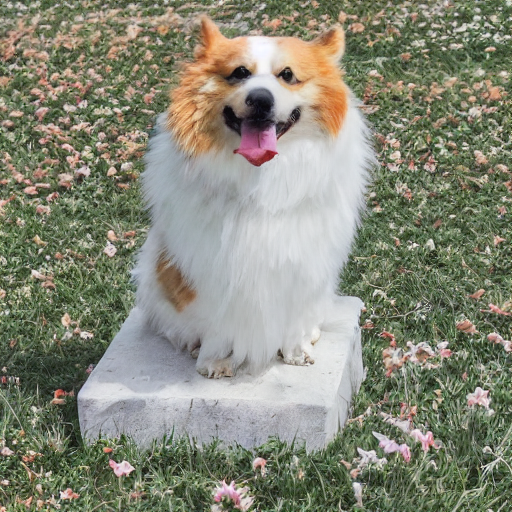

In [34]:
LORA_SCALE_UNET = 1 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1 #@param {type:"number"}
GUIDANCE = 3.6 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image